In [1]:
import pandas as pd
import os
import math

In [2]:
dir = '../../data/SPX_Data/'
                
                #  'Dates', 
                #  'Year', 
                #  'symbol',
                #  'gics_sector_name',
                #  'PX_LAST'


csv_files = [    
                 'DATE_OF_LAST_EXECUTIVE_CHANGE',
                 'TOT_STK_AWD_GIVEN_TO_CEO_EQUIV',
                 'TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV',
                 'TOT_BONUSES_PAID_TO_CEO_EQUIV',
                 'TOT_N_EQT_INCENT_GVN_TO_CEO_EQ',
                 'COMP_LKD_LAST_CEO_&_EQUIV_CHG_D',
                 'ALL_OTHER_COMP_AW_TO_CEO_EQUIV']

# csv_files = [f for f in os.listdir(dir) if f.endswith('.csv')]

#### get the coulomns with missing data (PXLAST & compensation)

In [3]:

X = []
for i in csv_files:
    data1 = pd.read_csv(dir+"/"+i+".csv")
    columns_with_nan = data1.columns[data1.isna().any()].tolist()
    X.append(columns_with_nan)

union = set(X[0]).union(*X[1:])
union_list = list(union)


In [4]:
PX_last_data = pd.read_csv("../../data/503PXlast.csv")
PX_last_data["DATES"] =  pd.to_datetime(PX_last_data["DATES"])
#get missing data for PX_last
PX_last_missing = PX_last_data.columns[PX_last_data.isna().any()].tolist()

union_list = set(PX_last_missing).union(union_list)
union_list = list(union_list)
print(len(union_list))


148


In [5]:
PX_last_data = PX_last_data.drop(union_list,axis=1) # drop missing data for now
PX_last_data_melt = pd.melt(PX_last_data,id_vars=['DATES'], var_name='symbol',value_name="PX_last")

In [6]:
merged_df = None

for file in csv_files:
    file_path = os.path.join(dir, file+".csv")
    df = pd.read_csv(file_path)
    df = df.drop(union_list,axis=1) # drop missing data for now 
    df["Date"] =  pd.to_datetime(df["Date"])
    file_name = os.path.splitext(file)[0]
    melted_df = pd.melt(df, id_vars=["Date"], var_name="symbol", value_name=file_name)
    
    if merged_df is None:
            merged_df = melted_df
    else:
        merged_df = pd.merge(merged_df, melted_df, on=["Date", "symbol"], how="outer")


#merged_df.to_csv("merged_data.csv", index=False)

In [7]:
#read in GICS data
data_GICS = pd.read_csv("../../data/503_GICSData.csv")

In [8]:
merged_df = pd.merge(merged_df,data_GICS,left_on="symbol",right_on="Symbol",how="left" )

### compute metric from bloomber governance sorce pg?

In [9]:
# add columns to data
merged_df.loc[:,"equity_Compensation_CEO"] = merged_df['TOT_STK_AWD_GIVEN_TO_CEO_EQUIV']+merged_df["TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV"]   # Equity compensation   = Total stock awards + Total option awards
merged_df.loc[:,"cash_incentive_CEO"] = merged_df['TOT_BONUSES_PAID_TO_CEO_EQUIV']+merged_df['TOT_N_EQT_INCENT_GVN_TO_CEO_EQ']         # Cash incentive        = Total bonuses paid + Total equity incentive given
merged_df.loc[:,"Variable_Pay_CEO"] = merged_df["cash_incentive_CEO"]+merged_df["equity_Compensation_CEO"]                             # Variable Pay          = Cash incentive + Equity incentive
merged_df.loc[:,"cash_incentive_CEO_percent"] = merged_df["cash_incentive_CEO"]/merged_df["Variable_Pay_CEO"]                          # Cash incentive ratio  = Cash incentive / (Cash incentive + Equity incentive)

#add years to both data sets
merged_df["year"]=merged_df["Date"].dt.year
PX_last_data_melt["year"]=PX_last_data_melt["DATES"].dt.year

In [10]:
merged_df.head()

,Date,symbol,DATE_OF_LAST_EXECUTIVE_CHANGE,TOT_STK_AWD_GIVEN_TO_CEO_EQUIV,TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV,TOT_BONUSES_PAID_TO_CEO_EQUIV,TOT_N_EQT_INCENT_GVN_TO_CEO_EQ,COMP_LKD_LAST_CEO_&_EQUIV_CHG_D,ALL_OTHER_COMP_AW_TO_CEO_EQUIV,Symbol,...,gics_sub_industry_name,gics_industry_name,gics_industry_group_name,gics_industry,gics_sector,equity_Compensation_CEO,cash_incentive_CEO,Variable_Pay_CEO,cash_incentive_CEO_percent,year
0,2014-12-31,A UN Equity,20140917,6632830,4569033,0,1631089.0,20050301,11233644.0,A UN Equity,...,Life Sciences Tools & Services,Life Sciences Tools & Services,"Pharmaceuticals, Biotechnology & Life Sciences",352030.0,35.0,11201863,1631089.0,12832952.0,0.127102,2014
1,2014-12-31,AAPL UW Equity,20140529,0,0,0,6700000.0,20110101,774176.0,AAPL UW Equity,...,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",Technology Hardware & Equipment,452020.0,45.0,0,6700000.0,6700000.0,1.000000,2014
2,2014-12-31,ABT UN Equity,20121231,4649999,4649997,0,3800000.0,19990101,11959164.0,ABT UN Equity,...,Health Care Equipment,Health Care Equipment & Supplies,Health Care Equipment & Services,351010.0,35.0,9299996,3800000.0,13099996.0,0.290076,2014
3,2014-12-31,ACGL UW Equity,20120901,3608010,959427,4500000,0.0,20030801,5539007.0,ACGL UW Equity,...,Property & Casualty Insurance,Insurance,Insurance,403010.0,40.0,4567437,4500000.0,9067437.0,0.496281,2014
4,2014-12-31,ACN UN Equity,20140831,11899930,0,0,2742937.0,20110101,12002728.0,ACN UN Equity,...,IT Consulting & Other Services,IT Services,Software & Services,451020.0,45.0,11899930,2742937.0,14642867.0,0.187322,2014


In [11]:
for symbol in PX_last_data_melt.groupby("symbol"):
    print(symbol)

('A UN Equity',             DATES       symbol     PX_last  year
143825 2015-01-02  A UN Equity   40.560000  2015
143826 2015-01-09  A UN Equity   40.590000  2015
143827 2015-01-16  A UN Equity   38.250000  2015
143828 2015-01-23  A UN Equity   38.810000  2015
143829 2015-01-30  A UN Equity   37.770000  2015
...           ...          ...         ...   ...
144343 2024-12-06  A UN Equity  140.580000  2024
144344 2024-12-13  A UN Equity  139.000000  2024
144345 2024-12-20  A UN Equity  134.510000  2024
144346 2024-12-27  A UN Equity  135.540000  2024
144347 2025-01-02  A UN Equity  133.660004  2025

[523 rows x 4 columns])
('AAPL UW Equity',            DATES          symbol     PX_last  year
90479 2015-01-02  AAPL UW Equity   27.332500  2015
90480 2015-01-09  AAPL UW Equity   28.002500  2015
90481 2015-01-16  AAPL UW Equity   26.497500  2015
90482 2015-01-23  AAPL UW Equity   28.245000  2015
90483 2015-01-30  AAPL UW Equity   29.290000  2015
...          ...             ...         ...  

In [12]:
PX_last_data_melt.keys()

Index(['DATES', 'symbol', 'PX_last', 'year'], dtype='object')

In [13]:
Columns=["gics_sector_name","symbol","year","cash_incentive_CEO_percent","returns"]
year_range = merged_df["year"].unique()
df = pd.DataFrame(columns=Columns)


#PX_last_data_melt[PX_last_data_melt["symbol"]=="AAPL UW Equity"].groupby("year")
for symbol,data1 in PX_last_data_melt.groupby("symbol"): 
    for y, data in data1.groupby("year"):
        if y in year_range: 
            returns=data["PX_last"].iloc[-1]/data["PX_last"].iloc[0]
            if symbol in merged_df["symbol"].unique():
                cash_incentive_CEO_percent=merged_df[(merged_df["symbol"]==symbol) & (merged_df["year"]==y)]["cash_incentive_CEO_percent"].iloc[0]
                gics_sector_name = merged_df[(merged_df["symbol"]==symbol) & (merged_df["year"]==y)]["gics_sector_name"].iloc[0]
                df2= {
                            "gics_sector_name":gics_sector_name,
                            "symbol":symbol,
                            "year":y,
                            "cash_incentive_CEO_percent":cash_incentive_CEO_percent,
                            "returns":returns          
                    }
                # df = df.append(df2, ignore_index = True)
                df = df._append(df2, ignore_index = True)
                #print("{} {} , {}".format(y,data["DATES"].iloc[0],data["DATES"].iloc[-1]))


/tmp/ipykernel_4247/802553863.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(df2, ignore_index = True)


# function to plot data using altair

In [16]:
import altair as alt

In [22]:
def plot_data(df, sector_index=-1):
  sector_names = data["gics_sector_name"].unique()

  if sector_index>-1:
    plot_title= sector_names[sector_index]
    df_plot= df[df["gics_sector_name"]==plot_title]
    color_name = "symbol"

    plot_title= "All sectors"
    df_plot = df

    color_name = "gics_sector_name"

    line = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule().encode(y='y')
    chart=alt.Chart(df_plot).mark_point().encode(
        x='cash_incentive_CEO_percent',
        y='returns',
        tooltip=["cash_incentive_CEO_percent","returns","symbol","year"],
        color = color_name,
        #shape="role:N"
    ).properties(
      title=plot_title).interactive()
  
  return line+chart

In [18]:
print(df)

     gics_sector_name         symbol  year  cash_incentive_CEO_percent  \
0         Health Care    A UN Equity  2015                    0.167618   
1         Health Care    A UN Equity  2016                    0.174255   
2         Health Care    A UN Equity  2017                    0.179859   
3         Health Care    A UN Equity  2018                    0.180233   
4         Health Care    A UN Equity  2019                    0.141610   
...               ...            ...   ...                         ...   
3181      Health Care  ZTS UN Equity  2019                    0.095536   
3182      Health Care  ZTS UN Equity  2020                    0.168060   
3183      Health Care  ZTS UN Equity  2021                    0.202077   
3184      Health Care  ZTS UN Equity  2022                    0.105004   
3185      Health Care  ZTS UN Equity  2023                    0.152544   

       returns  
0     1.038955  
1     1.089691  
2     1.395499  
3     0.943634  
4     1.304919  
...      

In [25]:
plot_data(df, 0)

KeyError: 'gics_sector_name'

plot sample charts

In [44]:
#list of stock in the SPX
print(PX_last_data_melt["symbol"].unique())

['LYB UN Equity' 'AXP UN Equity' 'VZ UN Equity' 'TPL UN Equity'
 'AVGO UW Equity' 'BA UN Equity' 'CAT UN Equity' 'JPM UN Equity'
 'CVX UN Equity' 'KO UN Equity' 'ABBV UN Equity' 'DIS UN Equity'
 'CPAY UN Equity' 'EXR UN Equity' 'XOM UN Equity' 'PSX UN Equity'
 'GE UN Equity' 'HPQ UN Equity' 'HD UN Equity' 'MPWR UW Equity'
 'IBM UN Equity' 'JNJ UN Equity' 'LULU UW Equity' 'MCD UN Equity'
 'MRK UN Equity' 'MMM UN Equity' 'AWK UN Equity' 'BAC UN Equity'
 'PFE UN Equity' 'PG UN Equity' 'T UN Equity' 'TRV UN Equity'
 'RTX UN Equity' 'ADI UW Equity' 'WMT UN Equity' 'CSCO UW Equity'
 'INTC UW Equity' 'GM UN Equity' 'MSFT UW Equity' 'DG UN Equity'
 'CI UN Equity' 'KMI UN Equity' 'C UN Equity' 'AIG UN Equity'
 'MO UN Equity' 'HCA UN Equity' 'IP UN Equity' 'ABT UN Equity'
 'AFL UN Equity' 'APD UN Equity' 'RCL UN Equity' 'HES UN Equity'
 'LII UN Equity' 'ADM UN Equity' 'ADP UW Equity' 'VRSK UW Equity'
 'AZO UN Equity' 'AVY UN Equity' 'ENPH UQ Equity' 'MSCI UN Equity'
 'BALL UN Equity' 'AXON UW Eq

<Axes: xlabel='DATES', ylabel='PX_last'>

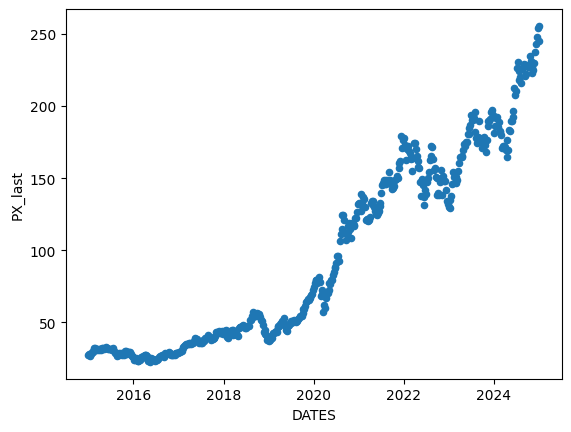

In [9]:
PX_last_data_melt[PX_last_data_melt["symbol"]=="AAPL UW Equity"].plot(kind="scatter",x="DATES",y="PX_last")

### idea to merge PX_last with excompensation (for ML)

In [18]:


# merged_df = pd.merge(merged_df, melted_df, on=["Date", "symbol"], how="outer")
# PX_last_data_melt

merged_df.info()

merged_df['Year'] = merged_df['Date'].dt.year
PX_last_data_melt['Year'] = PX_last_data_melt['DATES'].dt.year

display(merged_df)

final_merge = pd.merge(PX_last_data_melt, merged_df, on=['Year', 'symbol'], how='left')

display(final_merge)
final_merge.to_csv('final_merge.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5030 entries, 0 to 5029
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             5030 non-null   datetime64[ns]
 1   symbol                           5030 non-null   object        
 2   DATE_OF_LAST_EXECUTIVE_CHANGE    4897 non-null   float64       
 3   TOT_STK_AWD_GIVEN_TO_CEO_EQUIV   4872 non-null   float64       
 4   TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV   4816 non-null   float64       
 5   TOT_BONUSES_PAID_TO_CEO_EQUIV    4813 non-null   float64       
 6   TOT_N_EQT_INCENT_GVN_TO_CEO_EQ   4853 non-null   float64       
 7   COMP_LKD_LAST_CEO_&_EQUIV_CHG_D  4877 non-null   float64       
 8   ALL_OTHER_COMP_AW_TO_CEO_EQUIV   4879 non-null   float64       
 9   Year                             5030 non-null   int32         
dtypes: datetime64[ns](1), float64(7), int32(1), object(1)
memory

,Date,symbol,DATE_OF_LAST_EXECUTIVE_CHANGE,TOT_STK_AWD_GIVEN_TO_CEO_EQUIV,TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV,TOT_BONUSES_PAID_TO_CEO_EQUIV,TOT_N_EQT_INCENT_GVN_TO_CEO_EQ,COMP_LKD_LAST_CEO_&_EQUIV_CHG_D,ALL_OTHER_COMP_AW_TO_CEO_EQUIV,Year
0,2014-12-31,A UN Equity,20140917.0,6632830.0,4569033.0,0.0,1631089.0,20050301.0,11233644.0,2014
1,2014-12-31,AAPL UW Equity,20140529.0,0.0,0.0,0.0,6700000.0,20110101.0,774176.0,2014
2,2014-12-31,ABBV UN Equity,20140515.0,8379403.0,2762525.0,NaN,3500000.0,20130101.0,16910310.0,2014
3,2014-12-31,ABNB UW Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
4,2014-12-31,ABT UN Equity,20121231.0,4649999.0,4649997.0,0.0,3800000.0,19990101.0,11959164.0,2014
...,...,...,...,...,...,...,...,...,...,...
5025,2023-12-31,XYL UN Equity,20231231.0,5205980.0,1687514.0,0.0,2466750.0,20231231.0,7169777.0,2023
5026,2023-12-31,YUM UN Equity,20220101.0,9096602.0,2875016.0,0.0,4712500.0,20200101.0,15226455.0,2023
5027,2023-12-31,ZBH UN Equity,20230822.0,19222656.0,0.0,0.0,1603022.0,20230822.0,19539387.0,2023
5028,2023-12-31,ZBRA UW Equity,20231103.0,19000831.0,0.0,0.0,271769.0,20230301.0,19186185.0,2023


,DATES,symbol,PX_last,Year,Date,DATE_OF_LAST_EXECUTIVE_CHANGE,TOT_STK_AWD_GIVEN_TO_CEO_EQUIV,TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV,TOT_BONUSES_PAID_TO_CEO_EQUIV,TOT_N_EQT_INCENT_GVN_TO_CEO_EQ,COMP_LKD_LAST_CEO_&_EQUIV_CHG_D,ALL_OTHER_COMP_AW_TO_CEO_EQUIV
0,2015-01-02,LYB UN Equity,80.070000,2015,2015-12-31,20150601.0,12356319.0,6518771.0,0.0,4026937.0,20150112.0,20040667.0
1,2015-01-09,LYB UN Equity,78.980000,2015,2015-12-31,20150601.0,12356319.0,6518771.0,0.0,4026937.0,20150112.0,20040667.0
2,2015-01-16,LYB UN Equity,79.840000,2015,2015-12-31,20150601.0,12356319.0,6518771.0,0.0,4026937.0,20150112.0,20040667.0
3,2015-01-23,LYB UN Equity,80.800000,2015,2015-12-31,20150601.0,12356319.0,6518771.0,0.0,4026937.0,20150112.0,20040667.0
4,2015-01-30,LYB UN Equity,79.090000,2015,2015-12-31,20150601.0,12356319.0,6518771.0,0.0,4026937.0,20150112.0,20040667.0
...,...,...,...,...,...,...,...,...,...,...,...,...
263064,2024-12-06,MOH UN Equity,294.990000,2024,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263065,2024-12-13,MOH UN Equity,303.020000,2024,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263066,2024-12-20,MOH UN Equity,294.730000,2024,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263067,2024-12-27,MOH UN Equity,292.180000,2024,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
final_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263069 entries, 0 to 263068
Data columns (total 12 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   DATES                            263069 non-null  datetime64[ns]
 1   symbol                           263069 non-null  object        
 2   PX_last                          247334 non-null  float64       
 3   Year                             263069 non-null  int32         
 4   Date                             235940 non-null  datetime64[ns]
 5   DATE_OF_LAST_EXECUTIVE_CHANGE    230610 non-null  float64       
 6   TOT_STK_AWD_GIVEN_TO_CEO_EQUIV   229827 non-null  float64       
 7   TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV   228628 non-null  float64       
 8   TOT_BONUSES_PAID_TO_CEO_EQUIV    229046 non-null  float64       
 9   TOT_N_EQT_INCENT_GVN_TO_CEO_EQ   229148 non-null  float64       
 10  COMP_LKD_LAST_CEO_&_EQUIV_CHG_D  229879 non-

merged_df and PX_last_data_melt were merged to created final_merge

In [ ]:
# target_data = data[data['Variable_Pay_CEO'] == 0.0]